In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### 1. 随机调整图片的色彩，定义两种顺序。
* 调整亮度，饱和度，色相，对比度顺序会影响结果。

In [2]:
def distort_color(image, color_ordering=0):
    if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    return tf.clip_by_value(image, 0.0, 1.0)

#### 2. 对图片进行预处理，将图片转化成神经网络的输入层数据。

In [3]:
def preprocess_for_train(image, height, width, bbox):
    # 查看是否存在标注框。
    if bbox is None:
        # bbox:[ymin, xmin, ymax, xmax], 相对值
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32) # # [0, 1],float
        
    # 随机的截取图片中一个块。
    # 1. begin: A Tensor. Has the same type as image_size. 1-D, containing [offset_height, offset_width, 0]. Provide as input to tf.slice.
    # 2. bbox_size: A Tensor. Has the same type as image_size. 1-D, containing [target_height, target_width, -1]. Provide as input to tf.slice.
    # 3. _: A Tensor of type float32. 3-D with shape [1, 1, 4] containing the distorted bounding box. 
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox, min_object_covered=0.4)
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox, min_object_covered=0.4)
    # 剪切
    distorted_image = tf.slice(image, bbox_begin, bbox_size)

    # 将随机截取的图片调整为神经网络输入层的大小。
    distorted_image = tf.image.resize_images(distorted_image, [height, width], method=np.random.randint(4))
    # random_flip_left_right 
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    # distort_color, user defined.
    # np.random.randint: If high is None (the default), then results are from [0, low).
    distorted_image = distort_color(distorted_image, np.random.randint(2)) # [0,1]
    return distorted_image

#### 3. 读取图片。

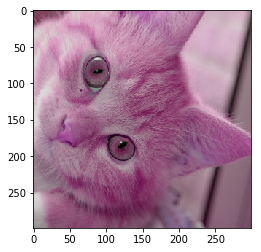

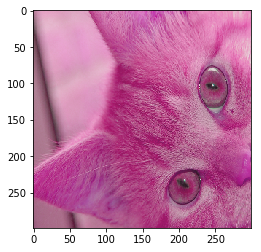

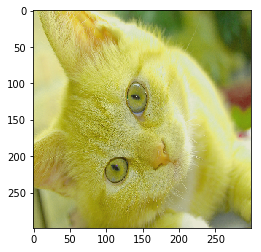

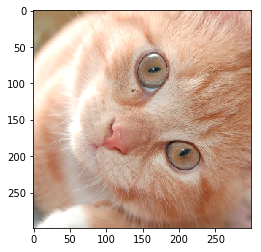

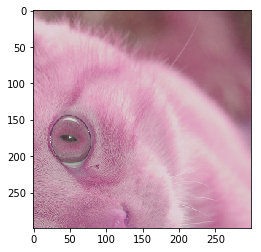

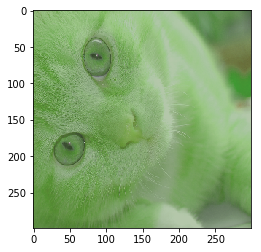

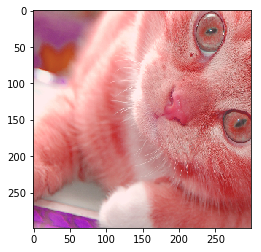

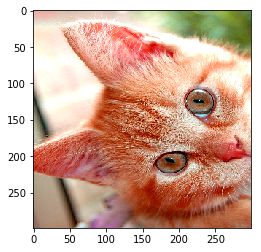

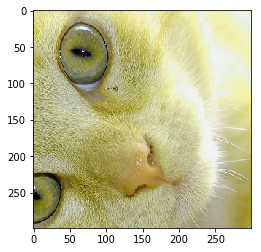

In [4]:
image_raw_data = tf.gfile.FastGFile("../0_datasets/cat.jpg", "rb").read()
with tf.Session() as sess:
    # 解码之后的结果为一个tensor,使用取值之前需要调用运行过程：img_data.eval()。
    img_data = tf.image.decode_jpeg(image_raw_data)
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    for i in range(9):
        result = preprocess_for_train(img_data, 299, 299, boxes)
        plt.imshow(result.eval())
        plt.show()